# Regression
Deep Learning - KI29  
Deggendorf Institute of Technology  
Prof. Dr. Florian Wahl

## Existierende Codebase

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nnfs
from nnfs.datasets import sine_data

In [2]:
# Dense Layer
class Layer_Dense:

    # Initialization Code
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initilalize weights and biases according to the shape given
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
        # Save Regularization Lambdas
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs):
        self.inputs = inputs

        # Calculate output as we did on the slides
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Regularisation
        # L1 weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
            
        # L2 weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
            
        # L1 biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
            
        # L2 biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        # Gradients on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [3]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs

        # Calculate the output based on inputs.
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        # Copy before we modify
        self.dinputs = dvalues.copy()

        # Set to 0 if value is <=0
        self.dinputs[self.inputs <= 0] = 0

In [4]:
class Loss:
    def calculate(self, output, y):
        # Calculate the per sample loss
        samples_losses = self.forward(output, y)

        # Calculate the mean loss and return it
        loss = np.mean(samples_losses)
        return loss
    
    def regularization_loss(self, layer):
        # Init return value to 0
        regularization_loss = 0
        
        # L1 weights
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            
        # L2 weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights ** 2)
            
        # L1 biases
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            
        # L2 biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases ** 2)
            
        return regularization_loss

In [5]:
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        n_samples = len(y_pred)  # Count the samples

        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip the predictions

        # Get correct confidence values
        # if labels are sparse
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(n_samples), y_true]

        # else if labels are one hot encoded
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        # Compute Losses
        losses = -np.log(correct_confidences)
        return losses

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)

        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues

        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [6]:
# Softmax activation
class Activation_Softmax:
    def forward(self, inputs):
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        # Normalize them for each sample
        self.output = probabilities

    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(
            zip(self.output, dvalues)
        ):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(
                single_output, single_output.T
            )

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [7]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy:
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):  # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded, # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [8]:
# SGD optimizer
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    # Update parameters
    def update_params(self, layer):
        if self.momentum:
            # If layer has no momentum arrays, create them
            if not hasattr(layer, "weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Compute weight updates
            weight_updates = (
                self.momentum * layer.weight_momentums
                - self.current_learning_rate * layer.dweights
            )
            layer.weight_momentums = weight_updates

            # Compute bias updates
            bias_updates = (
                self.momentum * layer.bias_momentums
                - self.current_learning_rate * layer.dbiases
            )
            layer.bias_momentums = bias_updates

        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Perform update
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

In [9]:
class Optimizer_Adagrad:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0, decay=0.0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    # Update parameters
    def update_params(self, layer):
        # If layer has no cache arrays, create them
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update the cache
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Compute weight updates
        layer.weights += (
            -self.current_learning_rate
            * layer.dweights
            / (np.sqrt(layer.weight_cache) + self.epsilon)
        )

        # Compute bias updates
        layer.biases += (
            -self.current_learning_rate
            * layer.dbiases
            / (np.sqrt(layer.bias_cache) + self.epsilon)
        )

    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

In [10]:
class Optimizer_RMSprop:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0, decay=0.0, epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    # Update parameters
    def update_params(self, layer):
        # If layer has no cache arrays, create them
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update the cache
        layer.weight_cache = (
            self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        )
        layer.bias_cache = (
            self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        )

        # Compute weight updates
        layer.weights += (
            -self.current_learning_rate
            * layer.dweights
            / (np.sqrt(layer.weight_cache) + self.epsilon)
        )

        # Compute bias updates
        layer.biases += (
            -self.current_learning_rate
            * layer.dbiases
            / (np.sqrt(layer.bias_cache) + self.epsilon)
        )

    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

In [11]:
class Optimizer_Adam:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=0.001, decay=0.0, epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    # Update parameters
    def update_params(self, layer):
        # If layer has no cache arrays, create them
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.bias_momentums = np.zeros_like(layer.biases)
            
        # Compute momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # Perform momentum correction using beta 1 (add +1 to avoid zero-division error)
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update the cache
        layer.weight_cache = (
            self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        )
        layer.bias_cache = (
            self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        )
        
        # Perform cache correction
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Compute weight updates
        layer.weights += (
            -self.current_learning_rate
            * weight_momentums_corrected
            / (np.sqrt(weight_cache_corrected) + self.epsilon)
        )

        # Compute bias updates
        layer.biases += (
            -self.current_learning_rate
            * bias_momentums_corrected
            / (np.sqrt(bias_cache_corrected) + self.epsilon)
        )

    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

In [12]:
class Layer_Dropout:
    def __init__(self, rate):
        # Store the dropout probability which is 1-dropout_rate
        self.rate = 1 - rate
        
    def forward(self, inputs):
        # Save inputs
        self.inputs = inputs
        
        # Generate dropout mask
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        
        # Apply output mask
        self.output = inputs * self.binary_mask
        
    def backward(self, dvalues):
        # Apply gradient on values
        self.dinputs = dvalues * self.binary_mask

In [13]:
class Activation_Sigmoid:
    def forward(self, inputs):
        # Save inputs and calculate output
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        
    def backward(self, dvalues):
        # Calculate derivate (remember to use the "trick")
        self.dinputs = dvalues * (1 - self.output) * self.output

In [14]:
# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

## Daten generieren

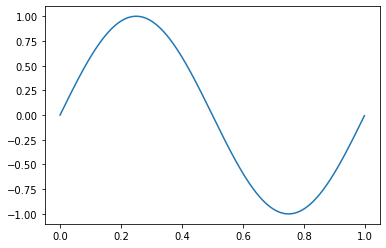

In [15]:
nnfs.init()

X, y = sine_data()

plt.plot(X, y)

## Lineare Aktivierungsfunktion

In [23]:
# Linear activation function
class Activation_Linear:
    def forward(self, inputs):
        ...
        
    def backward(self, dvalues):
        # Ableitung = 1
        ...

In [24]:
# Linear activation function
class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
        
    def backward(self, dvalues):
        # Ableitung = 1
        self.dinputs = dvalues.copy()

## Passende Loss Funktionen: MSE & MAE

In [ ]:
class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        ...
    
    def backward(self, dvalues, y_true):
        ...
        
        # Gradienten berechnen
        ...
        
        # Gradienten normalisieren
        ...

In [17]:
class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        samples_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return samples_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        # Gradienten berechnen
        self.dinputs = -2 * (y_true - dvalues) / outputs
        
        # Gradienten normalisieren
        self.dinputs = self.dinputs / samples

In [ ]:
class Loss_MeanAbsoluteError(Loss):
    def forward(self, y_pred, y_true):
        ...
    
    def backward(self, dvalues, y_true):
        ....

In [18]:
class Loss_MeanAbsoluteError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

## Evaluation

epoch: 0, acc: 0.002, loss: 0.500, data_loss: 0.500, reg_loss: 0.000, lr: 0.00100000
epoch: 500, acc: 0.003, loss: 0.146, data_loss: 0.146, reg_loss: 0.000, lr: 0.00100000
epoch: 1000, acc: 0.004, loss: 0.146, data_loss: 0.146, reg_loss: 0.000, lr: 0.00100000
epoch: 1500, acc: 0.004, loss: 0.145, data_loss: 0.145, reg_loss: 0.000, lr: 0.00100000
epoch: 2000, acc: 0.003, loss: 0.145, data_loss: 0.145, reg_loss: 0.000, lr: 0.00100000
epoch: 2500, acc: 0.003, loss: 0.145, data_loss: 0.145, reg_loss: 0.000, lr: 0.00100000
epoch: 3000, acc: 0.004, loss: 0.145, data_loss: 0.145, reg_loss: 0.000, lr: 0.00100000
epoch: 3500, acc: 0.003, loss: 0.145, data_loss: 0.145, reg_loss: 0.000, lr: 0.00100000
epoch: 4000, acc: 0.004, loss: 0.145, data_loss: 0.145, reg_loss: 0.000, lr: 0.00100000
epoch: 4500, acc: 0.004, loss: 0.145, data_loss: 0.145, reg_loss: 0.000, lr: 0.00100000
epoch: 5000, acc: 0.003, loss: 0.145, data_loss: 0.145, reg_loss: 0.000, lr: 0.00100000
epoch: 5500, acc: 0.004, loss: 0.145

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

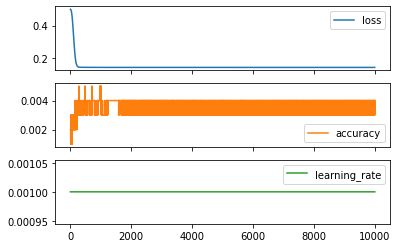

In [19]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(64, 1)
activation2 = Activation_Linear()

loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_Adam()

accuracy_band = np.std(y) / 250

losses = []
accuracies = []
learning_rates = []

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    data_loss = loss_function.calculate(activation2.output, y)
    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2)
    loss = data_loss + regularization_loss
    losses.append(loss)
    
    predictions = activation2.output
    accuracy = np.mean(np.abs(predictions - y) < accuracy_band)
    accuracies.append(accuracy)
    
    if not epoch % 500:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, '+
              f'loss: {loss:.3f}, ' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate:.8f}')
        
    # Backward pass
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    learning_rates.append(optimizer.current_learning_rate)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

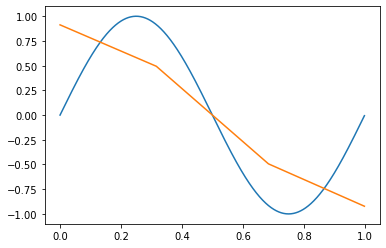

In [20]:
plt.figure()
X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation2.output)
plt.show()

epoch: 0, acc: 0.002, loss: 0.500, data_loss: 0.500, reg_loss: 0.000, lr: 0.05000000
epoch: 500, acc: 0.055, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.03335557
epoch: 1000, acc: 0.136, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.02501251
epoch: 1500, acc: 0.127, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.02000800
epoch: 2000, acc: 0.172, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.01667222
epoch: 2500, acc: 0.020, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.01428980
epoch: 3000, acc: 0.190, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.01250313
epoch: 3500, acc: 0.078, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.01111358
epoch: 4000, acc: 0.204, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.01000200
epoch: 4500, acc: 0.175, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00909256
epoch: 5000, acc: 0.190, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00833472
epoch: 5500, acc: 0.094, loss: 0.031

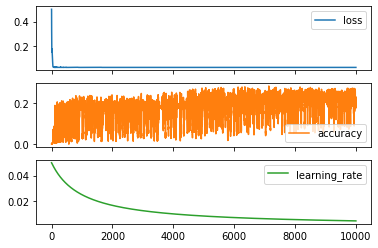

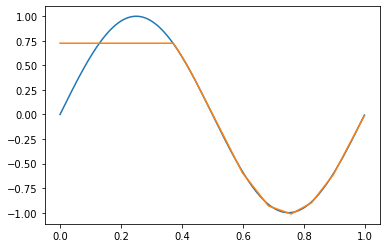

In [22]:
# More aggressive LR + add layer
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()

dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()

loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_Adam(learning_rate=0.05, decay=1e-3)

accuracy_band = np.std(y) / 250

losses = []
accuracies = []
learning_rates = []

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    
    data_loss = loss_function.calculate(activation3.output, y)
    regularization_loss = loss_function.regularization_loss(dense1) + \
                          loss_function.regularization_loss(dense2) + \
                          loss_function.regularization_loss(dense3)
    loss = data_loss + regularization_loss
    losses.append(loss)
    
    predictions = activation3.output
    accuracy = np.mean(np.abs(predictions - y) < accuracy_band)
    accuracies.append(accuracy)
    
    if not epoch % 500:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, '+
              f'loss: {loss:.3f}, ' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate:.8f}')
        
    # Backward pass
    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    learning_rates.append(optimizer.current_learning_rate)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

plt.figure()
X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()

epoch: 0, acc: 0.002, loss: 0.500, data_loss: 0.500, reg_loss: 0.000, lr: 0.00500000
epoch: 500, acc: 0.312, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00333556
epoch: 1000, acc: 0.372, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00250125
epoch: 1500, acc: 0.425, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00200080
epoch: 2000, acc: 0.539, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00166722
epoch: 2500, acc: 0.551, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00142898
epoch: 3000, acc: 0.548, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00125031
epoch: 3500, acc: 0.522, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00111136
epoch: 4000, acc: 0.554, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00100020
epoch: 4500, acc: 0.278, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00090926
epoch: 5000, acc: 0.560, loss: 0.031, data_loss: 0.031, reg_loss: 0.000, lr: 0.00083347
epoch: 5500, acc: 0.562, loss: 0.031

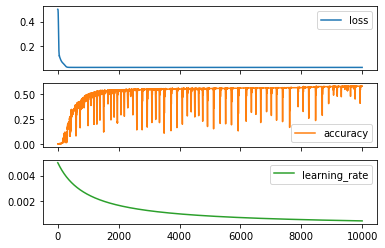

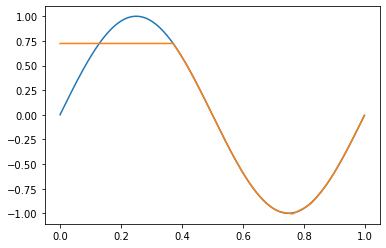

In [25]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()

dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()

loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_Adam(learning_rate=0.005, decay=1e-3)

accuracy_band = np.std(y) / 250

losses = []
accuracies = []
learning_rates = []

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    
    data_loss = loss_function.calculate(activation3.output, y)
    regularization_loss = loss_function.regularization_loss(dense1) + \
                          loss_function.regularization_loss(dense2) + \
                          loss_function.regularization_loss(dense3)
    loss = data_loss + regularization_loss
    losses.append(loss)
    
    predictions = activation3.output
    accuracy = np.mean(np.abs(predictions - y) < accuracy_band)
    accuracies.append(accuracy)
    
    if not epoch % 500:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, '+
              f'loss: {loss:.3f}, ' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate:.8f}')
        
    # Backward pass
    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    learning_rates.append(optimizer.current_learning_rate)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

plt.figure()
X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()

In [26]:
# Increase initial weights to improve model training

# Dense Layer
class Layer_Dense:

    # Initialization Code
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initilalize weights and biases according to the shape given
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
        # Save Regularization Lambdas
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs):
        self.inputs = inputs

        # Calculate output as we did on the slides
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Regularisation
        # L1 weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
            
        # L2 weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
            
        # L1 biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
            
        # L2 biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        # Gradients on values
        self.dinputs = np.dot(dvalues, self.weights.T)

epoch: 0, acc: 0.002, loss: 0.501, data_loss: 0.501, reg_loss: 0.000, lr: 0.00100000
epoch: 500, acc: 0.004, loss: 0.161, data_loss: 0.161, reg_loss: 0.000, lr: 0.00100000
epoch: 1000, acc: 0.003, loss: 0.158, data_loss: 0.158, reg_loss: 0.000, lr: 0.00100000
epoch: 1500, acc: 0.003, loss: 0.153, data_loss: 0.153, reg_loss: 0.000, lr: 0.00100000
epoch: 2000, acc: 0.005, loss: 0.143, data_loss: 0.143, reg_loss: 0.000, lr: 0.00100000
epoch: 2500, acc: 0.005, loss: 0.139, data_loss: 0.139, reg_loss: 0.000, lr: 0.00100000
epoch: 3000, acc: 0.015, loss: 0.137, data_loss: 0.137, reg_loss: 0.000, lr: 0.00100000
epoch: 3500, acc: 0.052, loss: 0.137, data_loss: 0.137, reg_loss: 0.000, lr: 0.00100000
epoch: 4000, acc: 0.075, loss: 0.137, data_loss: 0.137, reg_loss: 0.000, lr: 0.00100000
epoch: 4500, acc: 0.091, loss: 0.137, data_loss: 0.137, reg_loss: 0.000, lr: 0.00100000
epoch: 5000, acc: 0.107, loss: 0.137, data_loss: 0.137, reg_loss: 0.000, lr: 0.00100000
epoch: 5500, acc: 0.117, loss: 0.137

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

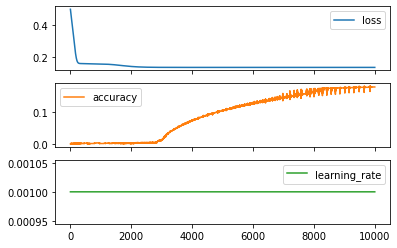

In [27]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(64, 1)
activation2 = Activation_Linear()

loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_Adam()

accuracy_band = np.std(y) / 250

losses = []
accuracies = []
learning_rates = []

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    data_loss = loss_function.calculate(activation2.output, y)
    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2)
    loss = data_loss + regularization_loss
    losses.append(loss)
    
    predictions = activation2.output
    accuracy = np.mean(np.abs(predictions - y) < accuracy_band)
    accuracies.append(accuracy)
    
    if not epoch % 500:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, '+
              f'loss: {loss:.3f}, ' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate:.8f}')
        
    # Backward pass
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    learning_rates.append(optimizer.current_learning_rate)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

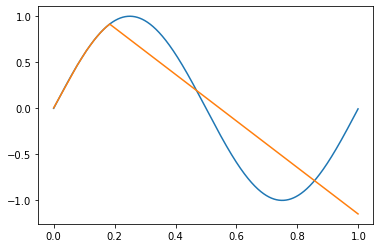

In [28]:
plt.figure()
X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation2.output)
plt.show()

epoch: 0, acc: 0.002, loss: 0.517, data_loss: 0.517, reg_loss: 0.000, lr: 0.00100000
epoch: 500, acc: 0.021, loss: 0.045, data_loss: 0.045, reg_loss: 0.000, lr: 0.00100000
epoch: 1000, acc: 0.497, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00100000
epoch: 1500, acc: 0.649, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00100000
epoch: 2000, acc: 0.658, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00100000
epoch: 2500, acc: 0.342, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00100000
epoch: 3000, acc: 0.701, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00100000
epoch: 3500, acc: 0.733, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00100000
epoch: 4000, acc: 0.731, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00100000
epoch: 4500, acc: 0.760, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00100000
epoch: 5000, acc: 0.784, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00100000
epoch: 5500, acc: 0.798, loss: 0.000

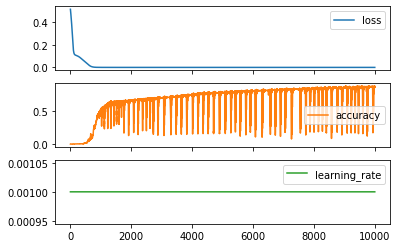

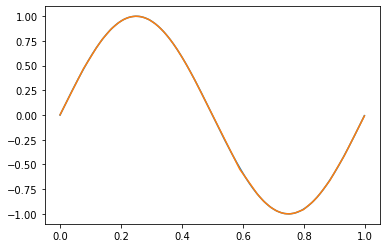

In [31]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()

dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()

loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_Adam()

accuracy_band = np.std(y) / 250

losses = []
accuracies = []
learning_rates = []

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    
    data_loss = loss_function.calculate(activation3.output, y)
    regularization_loss = loss_function.regularization_loss(dense1) + \
                          loss_function.regularization_loss(dense2) + \
                          loss_function.regularization_loss(dense3)
    loss = data_loss + regularization_loss
    losses.append(loss)
    
    predictions = activation3.output
    accuracy = np.mean(np.abs(predictions - y) < accuracy_band)
    accuracies.append(accuracy)
    
    if not epoch % 500:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, '+
              f'loss: {loss:.3f}, ' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate:.8f}')
        
    # Backward pass
    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    learning_rates.append(optimizer.current_learning_rate)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

plt.figure()
X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()

epoch: 0, acc: 0.002, loss: 0.498, data_loss: 0.498, reg_loss: 0.000, lr: 0.00500000
epoch: 500, acc: 0.601, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00333556
epoch: 1000, acc: 0.717, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00250125
epoch: 1500, acc: 0.757, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00200080
epoch: 2000, acc: 0.786, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00166722
epoch: 2500, acc: 0.792, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00142898
epoch: 3000, acc: 0.804, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00125031
epoch: 3500, acc: 0.812, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00111136
epoch: 4000, acc: 0.738, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00100020
epoch: 4500, acc: 0.813, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00090926
epoch: 5000, acc: 0.816, loss: 0.000, data_loss: 0.000, reg_loss: 0.000, lr: 0.00083347
epoch: 5500, acc: 0.820, loss: 0.000

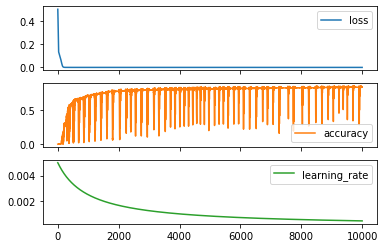

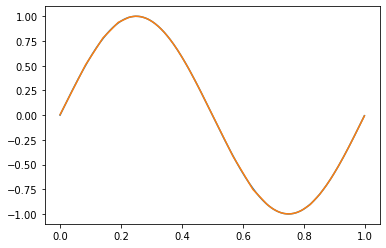

In [30]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()

dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()

loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_Adam(learning_rate=0.005, decay=1e-3)

accuracy_band = np.std(y) / 250

losses = []
accuracies = []
learning_rates = []

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    
    data_loss = loss_function.calculate(activation3.output, y)
    regularization_loss = loss_function.regularization_loss(dense1) + \
                          loss_function.regularization_loss(dense2) + \
                          loss_function.regularization_loss(dense3)
    loss = data_loss + regularization_loss
    losses.append(loss)
    
    predictions = activation3.output
    accuracy = np.mean(np.abs(predictions - y) < accuracy_band)
    accuracies.append(accuracy)
    
    if not epoch % 500:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, '+
              f'loss: {loss:.3f}, ' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate:.8f}')
        
    # Backward pass
    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    learning_rates.append(optimizer.current_learning_rate)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

plt.figure()
X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()